<a href="https://colab.research.google.com/github/Jis-4/Python-projects-/blob/main/Sales_Prediction_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'bigmart-sales-data:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F9961%2F14084%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240710%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240710T131711Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5e8477eb063eb513b1e5cda34106f7b7f75de90b0b1d477be5aef1fc6d378dda5ede19b2fc2b7dd8f72d5cd7b9dae69daa4c40eae3c37e980ee612996544252cfc2199da84c5b130b55049503bfab921f75ea9cce8fe46e564215d24b65f92f2883ff4cdaa4d6afa84968d50b5c1461dcc232c32bf7f871957ef67842a663f5c45be262de00755d10ae9bbb6499e63dd72933932490f61a29313c0d670f38bc92236980974c0219eac562549133d20b5f73c0df3240782626792fdbc588bd976ea3042d92ec0fdc77dba05c512274fd6edc140e95825dd41ffd9165ab8e33a8907ca3885df0a587cb49ce36ad274521f975c8dcad0f8cfeb9a5e011d47f386bc'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 314379 bytes downloaded
Downloaded and uncompressed: bigmart-sales-data
Data source import complete.


# **<font color = "purple">Sales Prediction</font>**

### **<font color = "green">Import Needed Libraries</font>**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor

from sklearn import metrics

from warnings import filterwarnings
filterwarnings('ignore')

### **<font color = "green">Data Collection and Processing</font>**

In [ ]:
#Read the data
df_train = pd.read_csv('/kaggle/input/bigmart-sales-data/Train.csv')

In [ ]:
#See first 10 rows
df_train.head(10)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
5,FDP36,10.395,Regular,0.000000,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088
6,FDO10,13.650,Regular,0.012741,Snack Foods,57.6588,OUT013,1987,High,Tier 3,Supermarket Type1,343.5528
7,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
8,FDH17,16.200,Regular,0.016687,Frozen Foods,96.9726,OUT045,2002,NaN,Tier 2,Supermarket Type1,1076.5986
9,FDU28,19.200,Regular,0.094450,Frozen Foods,187.8214,OUT017,2007,NaN,Tier 2,Supermarket Type1,4710.5350


In [ ]:
#print number of rows and columns separately

print("Number of Rows:",df_train.shape[0])
print("Number of Features:",df_train.shape[1])


Number of Rows: 8523
Number of Features: 12


In [ ]:
#see dataset information
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


**Numerical Features:**
- Item_Weight
- Item_Visibility
- Item_MRP
- Outlet_Establishment_Year
- Item_Outlet_Sales

-------------------------------------------------------------------------------------

**Categorical Features:**
- Item_Identifier
- Item_Fat_Content
- Item_Type
- Outlet_Identifier
- Outlet_Size
- Outlet_Location_Type
- Outlet_Type

-------------------------------------------------------------------------------------
**Columns that have null values:**
- Item_Weight
- Outlet_Size

In [ ]:
#Check for missing values
df_train.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

### **<font color = "green">Handling Missing Values</font>**

> ### **<font color = "brown">Mean Method to handle Missing Values in Item_Weight</font>**

In [ ]:
#Calculate Mean of Item_Weight column
df_train['Item_Weight'].mean()

12.857645184135976

In [ ]:
#Fill missing values in Item_Weight column with mean
df_train['Item_Weight'].fillna(df_train['Item_Weight'].mean(),inplace=True)

In [ ]:
#Check for missing values
df_train.isnull().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

### **<font color = "green">Handling Missing Values</font>**

> ### **<font color = "brown">Mode Method to handle Missing Values in Outlet_Size </font>**

In [ ]:
df_train['Outlet_Size'].value_counts()

Outlet_Size
Medium    2793
Small     2388
High       932
Name: count, dtype: int64

In [ ]:
#Calculate mode of Outlet_Size column for each Outlet_Type in Outlet_Size
df_train.groupby('Outlet_Type')['Outlet_Size'].agg(pd.Series.mode)

Outlet_Type
Grocery Store         Small
Supermarket Type1     Small
Supermarket Type2    Medium
Supermarket Type3    Medium
Name: Outlet_Size, dtype: object

In [ ]:
#Fill missing values in Outlet_Size column with mode of Outlet_Size column for each Outlet_Type in Outlet_Size
df_train.loc[df_train['Outlet_Type']=='Grocery Store','Outlet_Size']='Small'
df_train.loc[df_train['Outlet_Type']=='Supermarket Type1','Outlet_Size']='Small'
df_train.loc[df_train['Outlet_Type']=='Supermarket Type2','Outlet_Size']='Medium'
df_train.loc[df_train['Outlet_Type']=='Supermarket Type3','Outlet_Size']='Medium'

In [ ]:
#Check for missing values
df_train.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

### **<font color = "green">Data Analysis </font>**

In [ ]:
#See descriptive statistics of numerical columns
df_train.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.226124,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,9.310000,0.026989,93.826500,1987.000000,834.247400
50%,12.857645,0.053931,143.012800,1999.000000,1794.331000
75%,16.000000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


### **<font color = "green">Data Visualization of Numerical Features</font>**

In [ ]:
#applying Seaborn's default aesthetic settings to your plots
sns.set()

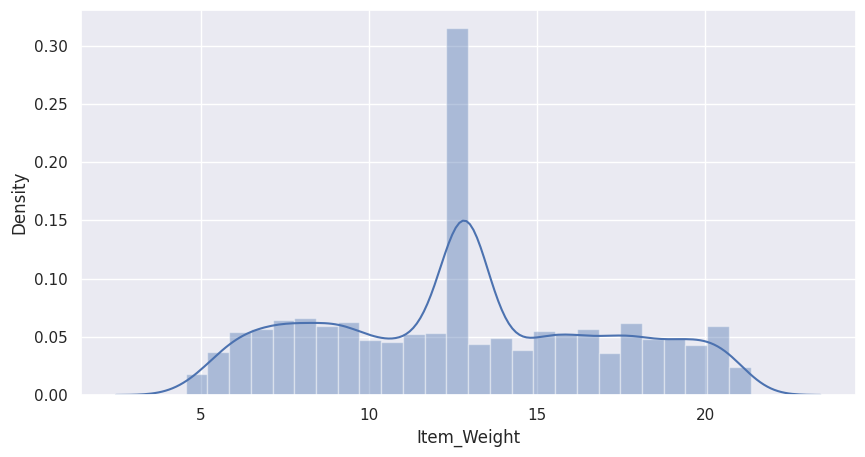

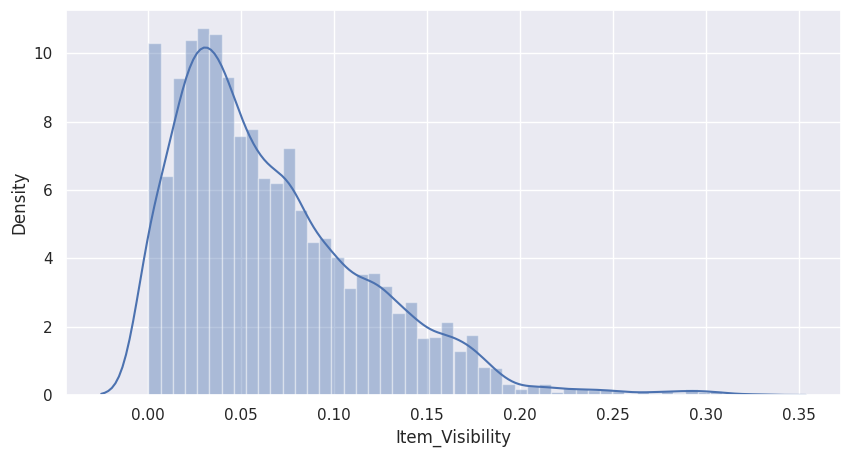

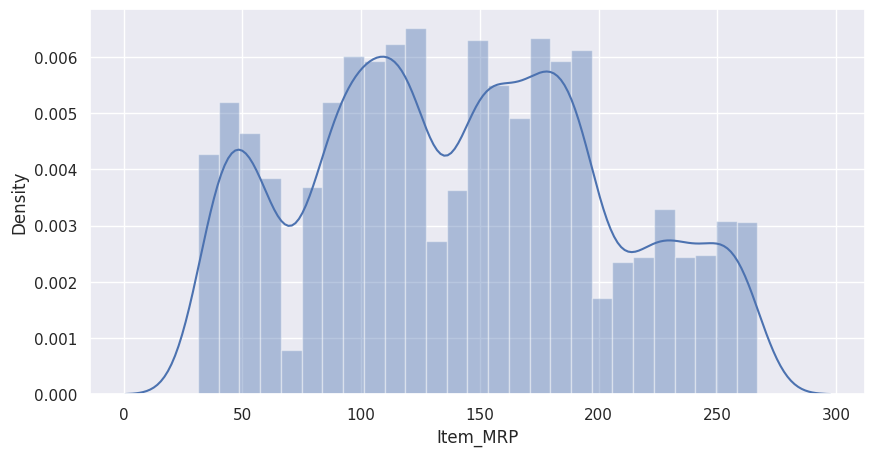

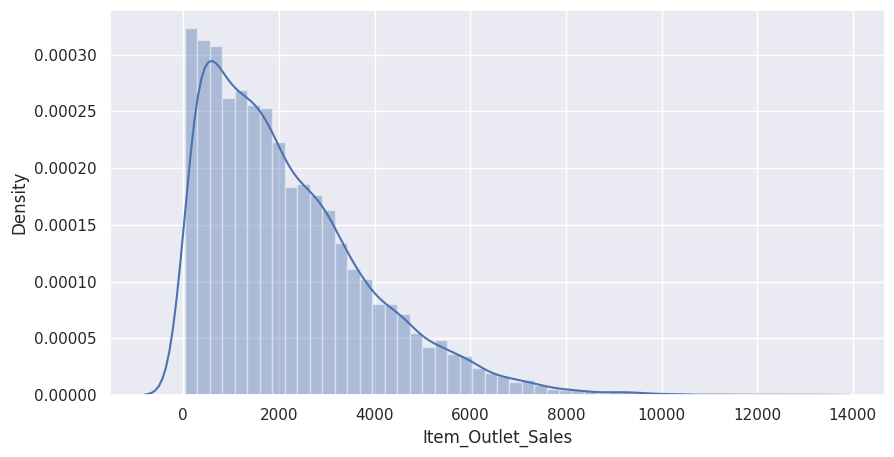

In [ ]:
#Plot distplot for numerical columns
cols = ['Item_Weight','Item_Visibility','Item_MRP','Item_Outlet_Sales']
for col in cols:
    plt.figure(figsize=(10,5))
    sns.distplot(df_train[col])
    plt.show()

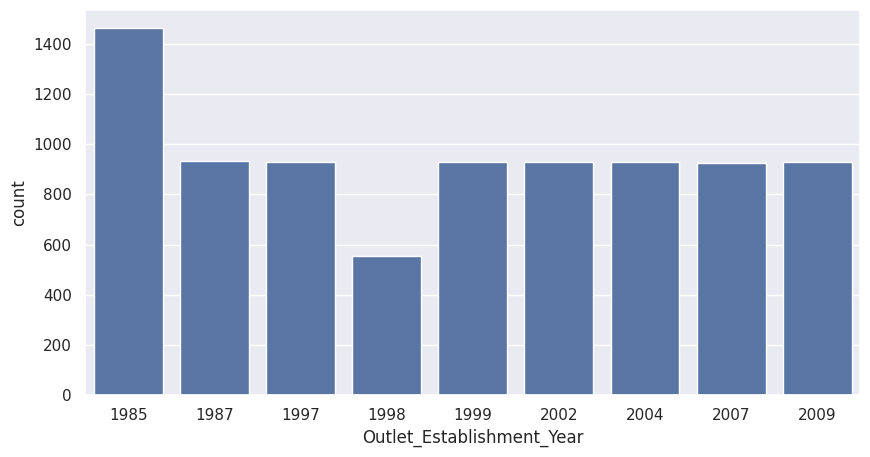

In [ ]:
#Plot countplot for Outlet_Establishment_Year column
plt.figure(figsize=(10,5))
sns.countplot(x='Outlet_Establishment_Year', data=df_train)
plt.show()

### **<font color = "green">Data Visualization of Categorical Features</font>**

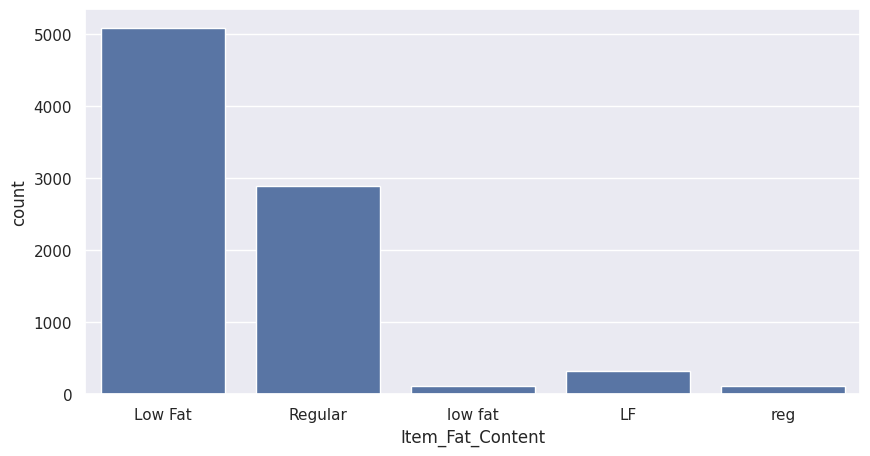

In [ ]:
#Plot countplot for Item_Fat_Content column
plt.figure(figsize=(10,5))
sns.countplot(x= "Item_Fat_Content" , data=df_train)
plt.show()

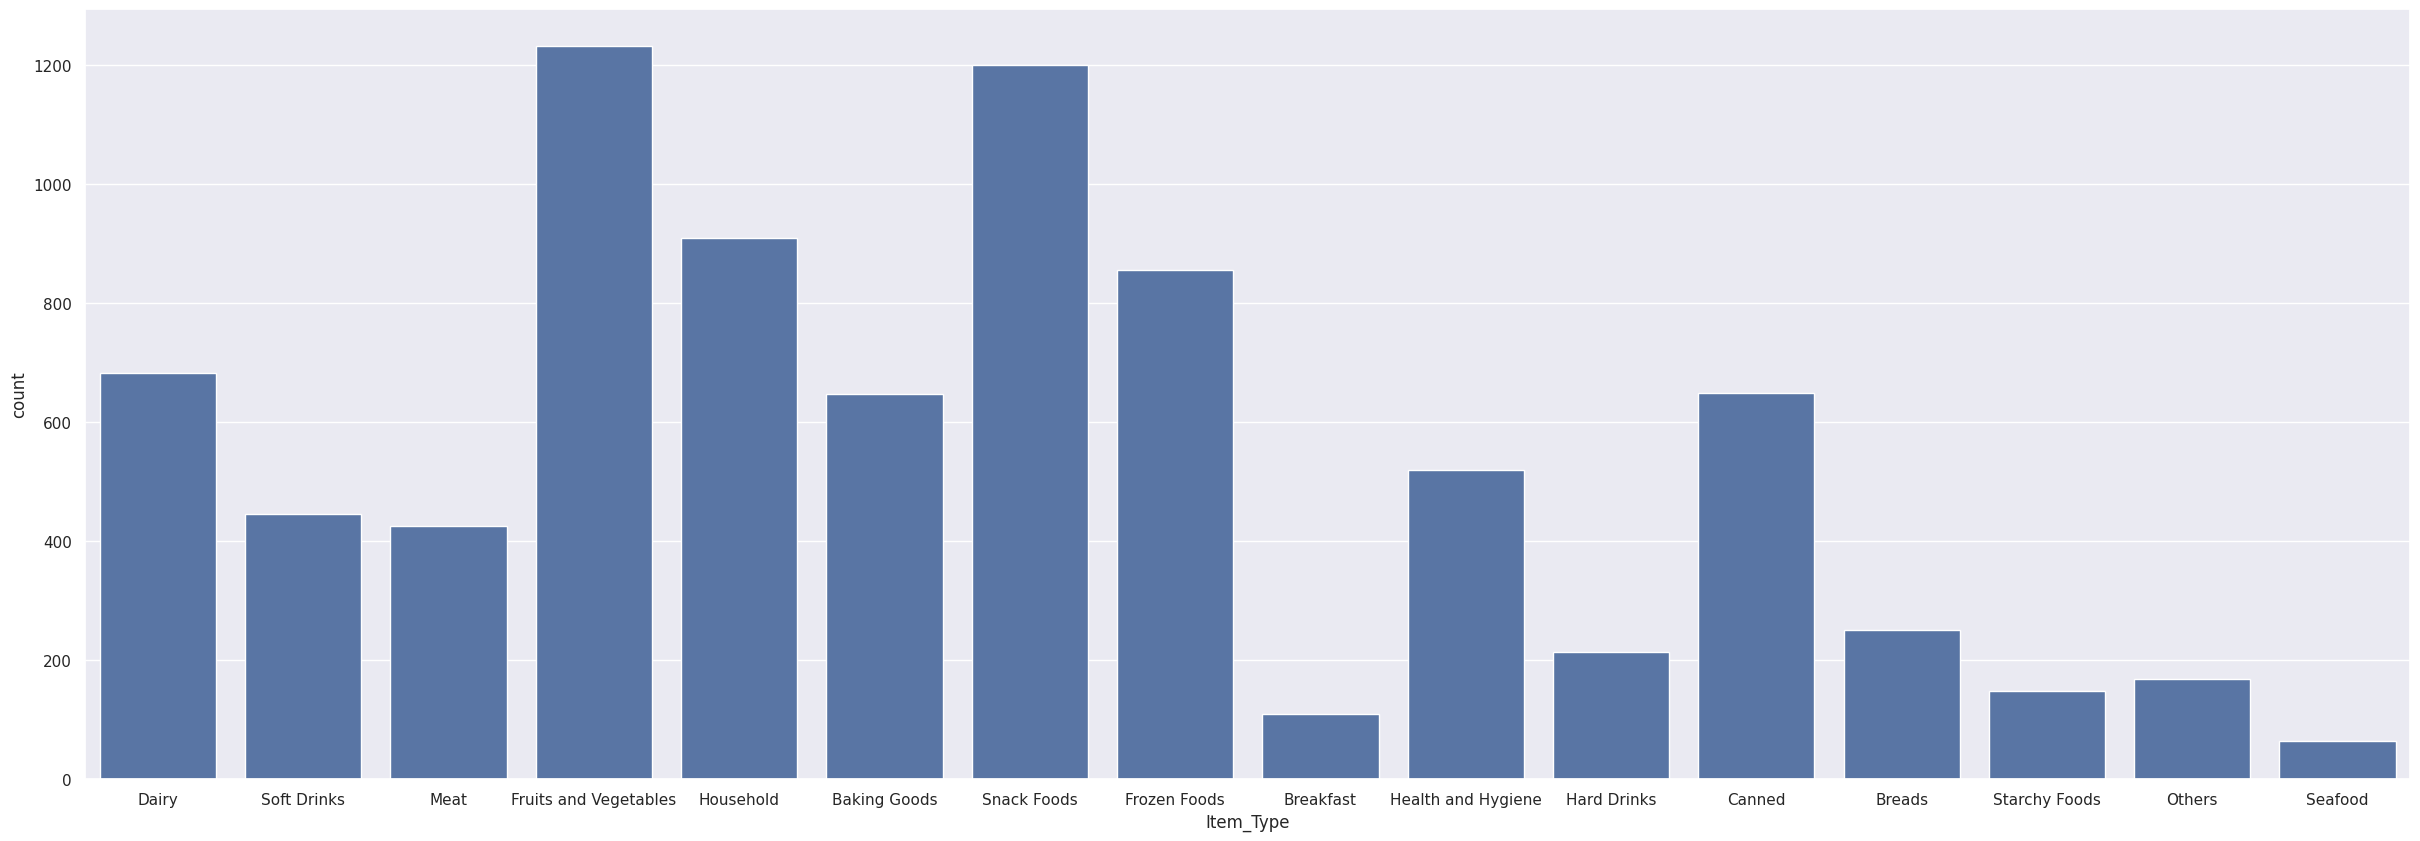

In [ ]:
#Plot countplot for Item_Type column
plt.figure(figsize=(30,10))
sns.countplot(x= "Item_Type" , data=df_train)
plt.show()

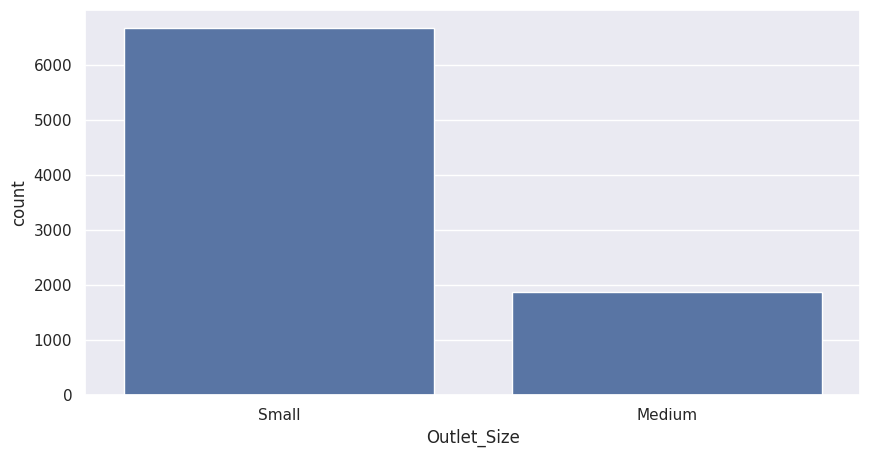

In [ ]:
#Plot countplot for Outlet_Size column
plt.figure(figsize=(10,5))
sns.countplot(x= "Outlet_Size" , data=df_train)
plt.show()

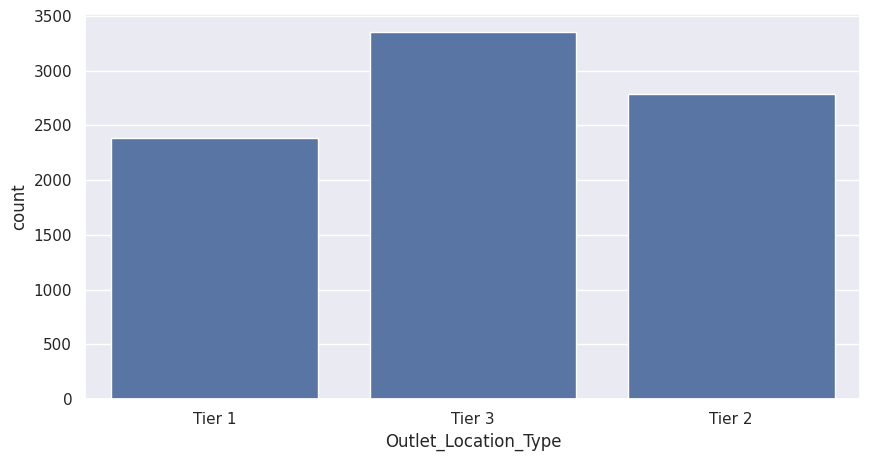

In [ ]:
#Plot countplot for Outlet_Location_Type column
plt.figure(figsize=(10,5))
sns.countplot(x= "Outlet_Location_Type" , data=df_train)
plt.show()

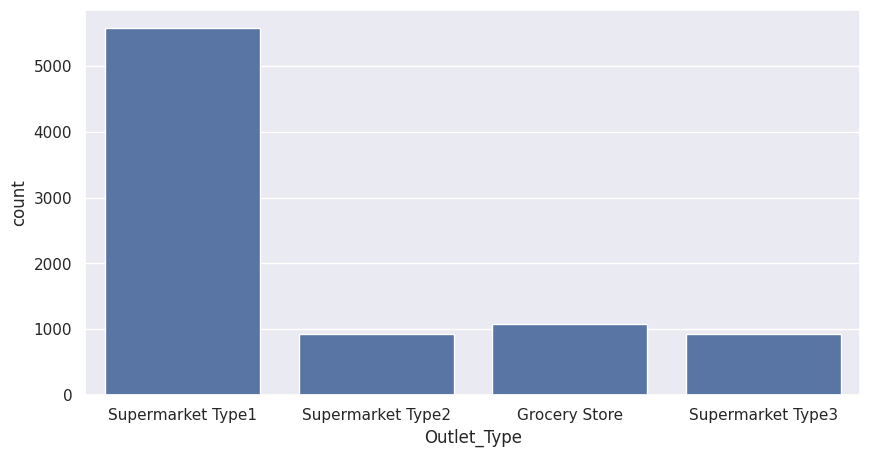

In [ ]:
#Plot countplot for Outlet_Type column
plt.figure(figsize=(10,5))
sns.countplot(x= "Outlet_Type" , data=df_train)
plt.show()

### **<font color = "green">Data Preprocessing</font>**

In [ ]:
#see categories in Item_Fat_Content column
df_train['Item_Fat_Content'].value_counts()

Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: count, dtype: int64

In [ ]:
#handle Item_Fat_Content column categories with replacement
df_train['Item_Fat_Content'].replace({'LF':'Low Fat','reg':'Regular','low fat':'Low Fat'},inplace=True)


In [ ]:
#see categories in Item_Fat_Content column
df_train['Item_Fat_Content'].value_counts()

Item_Fat_Content
Low Fat    5517
Regular    3006
Name: count, dtype: int64

### **<font color = "green">Handle Categorical Features</font>**

In [ ]:
#Apply Label Encoding on categorical columns
le = LabelEncoder()

df_train['Item_Fat_Content'] = le.fit_transform(df_train['Item_Fat_Content'])

df_train['Item_Type'] = le.fit_transform(df_train['Item_Type'])

df_train['Outlet_Size'] = le.fit_transform(df_train['Outlet_Size'])

df_train['Outlet_Location_Type'] = le.fit_transform(df_train['Outlet_Location_Type'])

df_train['Outlet_Type'] = le.fit_transform(df_train['Outlet_Type'])

df_train['Item_Identifier'] = le.fit_transform(df_train['Item_Identifier'])

df_train['Outlet_Identifier'] = le.fit_transform(df_train['Outlet_Identifier'])

In [ ]:
df_train.head(10)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,156,9.300000,0,0.016047,4,249.8092,9,1999,1,0,1,3735.1380
1,8,5.920000,1,0.019278,14,48.2692,3,2009,0,2,2,443.4228
2,662,17.500000,0,0.016760,10,141.6180,9,1999,1,0,1,2097.2700
3,1121,19.200000,1,0.000000,6,182.0950,0,1998,1,2,0,732.3800
4,1297,8.930000,0,0.000000,9,53.8614,1,1987,1,2,1,994.7052
5,758,10.395000,1,0.000000,0,51.4008,3,2009,0,2,2,556.6088
6,696,13.650000,1,0.012741,13,57.6588,1,1987,1,2,1,343.5528
7,738,12.857645,0,0.127470,13,107.7622,5,1985,0,2,3,4022.7636
8,440,16.200000,1,0.016687,5,96.9726,7,2002,1,1,1,1076.5986
9,990,19.200000,1,0.094450,5,187.8214,2,2007,1,1,1,4710.5350


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   int64  
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   int64  
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   int64  
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   int64  
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                8523 non-null   int64  
 9   Outlet_Location_Type       8523 non-null   int64  
 10  Outlet_Type                8523 non-null   int64  
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(8)
memory usage: 799.2 KB


### **<font color = "green">Data Scaling using StandardScaler</font>**

In [ ]:
sc = StandardScaler()

df_train['Item_Weight'] = sc.fit_transform(df_train['Item_Weight'].values.reshape(-1,1))

df_train['Item_Visibility'] = sc.fit_transform(df_train['Item_Visibility'].values.reshape(-1,1))

df_train['Item_MRP'] = sc.fit_transform(df_train['Item_MRP'].values.reshape(-1,1))

df_train['Item_Outlet_Sales'] = sc.fit_transform(df_train['Item_Outlet_Sales'].values.reshape(-1,1))

df_train.head(10)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,156,-0.841872,0,-0.970732,4,1.747454,9,1999,1,0,1,0.910601
1,8,-1.641706,1,-0.908111,14,-1.489023,3,2009,0,2,2,-1.018440
2,662,1.098554,0,-0.956917,10,0.010040,9,1999,1,0,1,-0.049238
3,1121,1.500838,1,-1.281758,6,0.660050,0,1998,1,2,0,-0.849103
4,1297,-0.929428,0,-1.281758,9,-1.399220,1,1987,1,2,1,-0.695373
5,758,-0.582754,1,-1.281758,0,-1.438734,3,2009,0,2,2,-0.952110
6,696,0.187501,1,-1.034813,13,-1.338238,1,1987,1,2,1,-1.076967
7,738,0.000000,0,1.188838,13,-0.533641,5,1985,0,2,3,1.079158
8,440,0.790926,1,-0.958331,5,-0.706908,7,2002,1,1,1,-0.647381
9,990,1.500838,1,0.548845,5,0.752008,2,2007,1,1,1,1.482212


### **<font color = "green">Seperate Features from Label</font>**

In [ ]:
#sepertate features and target

Features = df_train.drop(columns=['Item_Outlet_Sales'])

Target = df_train['Item_Outlet_Sales']

In [ ]:
Features

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,156,-0.841872,0,-0.970732,4,1.747454,9,1999,1,0,1
1,8,-1.641706,1,-0.908111,14,-1.489023,3,2009,0,2,2
2,662,1.098554,0,-0.956917,10,0.010040,9,1999,1,0,1
3,1121,1.500838,1,-1.281758,6,0.660050,0,1998,1,2,0
4,1297,-0.929428,0,-1.281758,9,-1.399220,1,1987,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...
8518,370,-1.418084,0,-0.181193,13,1.180783,1,1987,1,2,1
8519,897,-1.059578,1,-0.371154,0,-0.527301,7,2002,1,1,1
8520,1357,-0.534243,0,-0.599784,8,-0.897208,6,2004,1,1,1
8521,681,-1.336444,1,1.532880,13,-0.607977,3,2009,0,2,2


In [ ]:
Target

0       0.910601
1      -1.018440
2      -0.049238
3      -0.849103
4      -0.695373
          ...   
8518    0.349915
8519   -0.956402
8520   -0.579100
8521   -0.196725
8522   -0.829594
Name: Item_Outlet_Sales, Length: 8523, dtype: float64

### **<font color = "green">Split data into train and test sets</font>**

In [ ]:
#splittting data into training and testing data
Features_train,Features_test,Target_train,Target_test = train_test_split(Features,Target,test_size=0.2,random_state=42)

In [ ]:
#print shape of features and training and testing data of features
print("Shape of Features:",Features.shape)
print("Shape of Features_train:",Features_train.shape)
print("Shape of Features_test:",Features_test.shape)

Shape of Features: (8523, 11)
Shape of Features_train: (6818, 11)
Shape of Features_test: (1705, 11)


In [ ]:
#print shape of Target and training and testing data of Target
print("Shape of Target:",Target.shape)
print("Shape of Target_train:",Target_train.shape)
print("Shape of Target_test:",Target_test.shape)

Shape of Target: (8523,)
Shape of Target_train: (6818,)
Shape of Target_test: (1705,)


### **<font color = "green">Building Model</font>**

#### **<font color = "purple">Building  XGBRegressor Model</font>**

In [ ]:
#build model with XGBRegressor
XGBRModel = XGBRegressor()

#fit the model
XGBRModel.fit(Features_train,Target_train)

#predict the model
Target_pred = XGBRModel.predict(Features_test)

#calculate R-Squared
r2_score = metrics.r2_score(Target_test,Target_pred)
print("R-Squared:",r2_score)

#calculate Mean Absolute Error
mae = metrics.mean_absolute_error(Target_test,Target_pred)
print("Mean Absolute Error:",mae)

#calculate Mean Squared Error
mse = metrics.mean_squared_error(Target_test,Target_pred)
print("Mean Squared Error:",mse)


R-Squared: 0.5119126417237851
Mean Absolute Error: 0.47173654608004656
Mean Squared Error: 0.45559693922553346


#### **<font color = "purple">Building  SVR Model</font>**

In [ ]:
#build model with SVLRegressor
model = SVR()

#fit the model
model.fit(Features_train,Target_train)

#predict the model
Target_pred = model.predict(Features_test)

#calculate R-Squared
r2_score = metrics.r2_score(Target_test,Target_pred)
print("R-Squared:",r2_score)

#calculate Mean Absolute Error
mae = metrics.mean_absolute_error(Target_test,Target_pred)
print("Mean Absolute Error:",mae)

#calculate Mean Squared Error
mse = metrics.mean_squared_error(Target_test,Target_pred)
print("Mean Squared Error:",mse)

R-Squared: -0.024447002815127128
Mean Absolute Error: 0.7432809334031226
Mean Squared Error: 0.9562528325456281


#### **<font color = "purple">Building RandomForestRegressor Model</font>**

In [ ]:
#build model with RandomForestRegressor
model = RandomForestRegressor()

#fit the model
model.fit(Features_train,Target_train)

#predict the model
Target_pred = model.predict(Features_test)

#calculate R-Squared
r2_score = metrics.r2_score(Target_test,Target_pred)
print("R-Squared:",r2_score)

#calculate Mean Absolute Error
mae = metrics.mean_absolute_error(Target_test,Target_pred)
print("Mean Absolute Error:",mae)

#calculate Mean Squared Error
mse = metrics.mean_squared_error(Target_test,Target_pred)
print("Mean Squared Error:",mse)


R-Squared: 0.5524384208463708
Mean Absolute Error: 0.45055266459890186
Mean Squared Error: 0.4177688319924602


In [ ]:
pip install lazypredict

In [ ]:
#Build Lazy Predict Model
from lazypredict.Supervised import LazyRegressor

#Build Lazy Predict Model
reg = LazyRegressor(verbose=0,ignore_warnings=False,custom_metric=None)
models,predictions = reg.fit(Features_train,Features_test,Target_train,Target_test)

#Print model performance
print(models)

 21%|██▏       | 9/42 [00:07<00:50,  1.53s/it]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.


 76%|███████▌  | 32/42 [00:46<00:07,  1.27it/s]

PoissonRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.
QuantileRegressor model failed to execute
Solver interior-point is not anymore available in SciPy >= 1.11.0.


100%|██████████| 42/42 [00:54<00:00,  1.30s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000626 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 6818, number of used features: 11
[LightGBM] [Info] Start training from score 0.012351
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
NuSVR                                        0.61       0.61  0.60        4.00
SVR                                          0.61       0.61  0.60        2.90
MLPRegressor                                 0.61       0.61  0.61        4.22
GradientBoostingRegressor                    0.60       0.60  0.61        1.68
LGBMRegressor                                0.59       0.59  0.62        0.18
HistGradientBoostingRegressor             

In [ ]:
#build model with GradientBoostingRegressor
model = GradientBoostingRegressor()

#fit the model
model.fit(Features_train,Target_train)

#predict the model
Target_pred = model.predict(Features_test)

#calculate R-Squared
r2_score = metrics.r2_score(Target_test,Target_pred)
print("R-Squared:",r2_score)

#calculate Mean Absolute Error
mae = metrics.mean_absolute_error(Target_test,Target_pred)
print("Mean Absolute Error:",mae)

#calculate Mean Squared Error
mse = metrics.mean_squared_error(Target_test,Target_pred)
print("Mean Squared Error:",mse)

R-Squared: 0.6034031869311423
Mean Absolute Error: 0.42474310397989484
Mean Squared Error: 0.37019662787192853


In [ ]:
#build model with LGBMRegressor
model = LGBMRegressor()

#fit the model
model.fit(Features_train,Target_train)

#predict the model
Target_pred = model.predict(Features_test)

#calculate R-Squared
r2_score = metrics.r2_score(Target_test,Target_pred)
print("R-Squared:",r2_score)

#calculate Mean Absolute Error
mae = metrics.mean_absolute_error(Target_test,Target_pred)
print("Mean Absolute Error:",mae)

#calculate Mean Squared Error
mse = metrics.mean_squared_error(Target_test,Target_pred)
print("Mean Squared Error:",mse)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1027
[LightGBM] [Info] Number of data points in the train set: 6818, number of used features: 11
[LightGBM] [Info] Start training from score 0.012351
R-Squared: 0.5865680743618109
Mean Absolute Error: 0.43394911824178806
Mean Squared Error: 0.3859110806805262


In [ ]:
#Save the model
from joblib import dump
dump(XGBRModel, 'XGBRegressor.joblib')

['XGBRegressor.joblib']

### **<font color = "green">Make a predictive System</font>**

In [ ]:
#Read test data
df_test = pd.read_csv('/kaggle/input/bigmart-sales-data/Test.csv')
df_test.head(10)


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.75,Low Fat,0.01,Snack Foods,107.86,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.30,reg,0.04,Dairy,87.32,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.60,Low Fat,0.10,Others,241.75,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.32,Low Fat,0.02,Snack Foods,155.03,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.12,Dairy,234.23,OUT027,1985,Medium,Tier 3,Supermarket Type3
5,FDH56,9.80,Regular,0.06,Fruits and Vegetables,117.15,OUT046,1997,Small,Tier 1,Supermarket Type1
6,FDL48,19.35,Regular,0.08,Baking Goods,50.10,OUT018,2009,Medium,Tier 3,Supermarket Type2
7,FDC48,NaN,Low Fat,0.02,Baking Goods,81.06,OUT027,1985,Medium,Tier 3,Supermarket Type3
8,FDN33,6.30,Regular,0.12,Snack Foods,95.74,OUT045,2002,NaN,Tier 2,Supermarket Type1
9,FDA36,5.99,Low Fat,0.01,Baking Goods,186.89,OUT017,2007,NaN,Tier 2,Supermarket Type1


In [ ]:
df_test.shape

(5681, 11)

### **<font color = "green">PreProcessing test data</font>**

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5681 entries, 0 to 5680
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            5681 non-null   object 
 1   Item_Weight                4705 non-null   float64
 2   Item_Fat_Content           5681 non-null   object 
 3   Item_Visibility            5681 non-null   float64
 4   Item_Type                  5681 non-null   object 
 5   Item_MRP                   5681 non-null   float64
 6   Outlet_Identifier          5681 non-null   object 
 7   Outlet_Establishment_Year  5681 non-null   int64  
 8   Outlet_Size                4075 non-null   object 
 9   Outlet_Location_Type       5681 non-null   object 
 10  Outlet_Type                5681 non-null   object 
dtypes: float64(3), int64(1), object(7)
memory usage: 488.3+ KB


In [ ]:
#see categories in Item_Fat_Content column
df_test['Item_Fat_Content'].value_counts()

Item_Fat_Content
Low Fat    3396
Regular    1935
LF          206
reg          78
low fat      66
Name: count, dtype: int64

In [ ]:
#handle Item_Fat_Content column categories with replacement
df_test['Item_Fat_Content'].replace({'LF':'Low Fat','reg':'Regular','low fat':'Low Fat'},inplace=True)

In [ ]:
#see categories in Item_Fat_Content column
df_test['Item_Fat_Content'].value_counts()

Item_Fat_Content
Low Fat    3668
Regular    2013
Name: count, dtype: int64

In [ ]:
#Apply Label Encoding on categorical columns
le = LabelEncoder()

df_test['Item_Fat_Content'] = le.fit_transform(df_test['Item_Fat_Content'])

df_test['Item_Type'] = le.fit_transform(df_test['Item_Type'])

df_test['Outlet_Size'] = le.fit_transform(df_test['Outlet_Size'])

df_test['Outlet_Location_Type'] = le.fit_transform(df_test['Outlet_Location_Type'])

df_test['Outlet_Type'] = le.fit_transform(df_test['Outlet_Type'])

df_test['Item_Identifier'] = le.fit_transform(df_test['Item_Identifier'])

df_test['Outlet_Identifier'] = le.fit_transform(df_test['Outlet_Identifier'])

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5681 entries, 0 to 5680
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            5681 non-null   int64  
 1   Item_Weight                4705 non-null   float64
 2   Item_Fat_Content           5681 non-null   int64  
 3   Item_Visibility            5681 non-null   float64
 4   Item_Type                  5681 non-null   int64  
 5   Item_MRP                   5681 non-null   float64
 6   Outlet_Identifier          5681 non-null   int64  
 7   Outlet_Establishment_Year  5681 non-null   int64  
 8   Outlet_Size                5681 non-null   int64  
 9   Outlet_Location_Type       5681 non-null   int64  
 10  Outlet_Type                5681 non-null   int64  
dtypes: float64(3), int64(8)
memory usage: 488.3 KB


In [ ]:
sc = StandardScaler()

df_test['Item_Weight'] = sc.fit_transform(df_test['Item_Weight'].values.reshape(-1,1))

df_test['Item_Visibility'] = sc.fit_transform(df_test['Item_Visibility'].values.reshape(-1,1))

df_test['Item_MRP'] = sc.fit_transform(df_test['Item_MRP'].values.reshape(-1,1))

df_test.head(10)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,1103,1.73,0,-1.13,13,-0.54,9,1999,1,0,1
1,1067,-0.94,1,-0.53,4,-0.87,2,2007,3,1,1
2,1406,0.41,0,0.66,11,1.63,0,1998,3,2,0
3,809,-1.15,0,-0.98,13,0.23,2,2007,3,1,1
4,1184,NaN,1,1.03,4,1.51,5,1985,1,2,3
5,461,-0.62,1,-0.04,6,-0.39,8,1997,2,0,1
6,604,1.43,1,0.33,0,-1.47,3,2009,1,2,2
7,266,NaN,0,-0.97,0,-0.97,5,1985,1,2,3
8,668,-1.37,1,1.13,13,-0.73,7,2002,3,1,1
9,170,-1.44,0,-1.17,0,0.74,2,2007,3,1,1


In [ ]:
#load trained model
from joblib import load

model = load('XGBRegressor.joblib')

#predict the model
Target_pred = model.predict(df_test)


In [ ]:
#print each Item_Identifier with its predicted value and put the result in dataframe
df = pd.DataFrame({'Item_Identifier':df_test['Item_Identifier'],'Item_Outlet_Sales':Target_pred})
df


,Item_Identifier,Item_Outlet_Sales
0,1103,-0.32
1,1067,-0.57
2,1406,-1.09
3,809,0.08
4,1184,3.16
...,...,...
5676,231,0.10
5677,306,-0.16
5678,1412,0.02
5679,517,1.22


from matplotlib import pyplot as plt
df['Item_Identifier'].plot(kind='hist', bins=20, title='Item_Identifier')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['Item_Outlet_Sales'].plot(kind='hist', bins=20, title='Item_Outlet_Sales')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='Item_Identifier', y='Item_Outlet_Sales', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['Item_Identifier'].plot(kind='line', figsize=(8, 4), title='Item_Identifier')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['Item_Outlet_Sales'].plot(kind='line', figsize=(8, 4), title='Item_Outlet_Sales')
plt.gca().spines[['top', 'right']].set_visible(False)